## Introduction

In this project, I will implement a classifier which can classify **CIFAR-10** [1] dataset. This dataset contains these classes:
* airplane (0), automobile (1), bird (2), cat (3), deer (4), dog (5), frog (6), horse (7), ship (8), truck (9)

All these classes are ranging from 0 to 9 in the dataset.

I will consider **ResNet-50** [2] convolutional neural network architecture. Transfer learning technique is used for training the model. I will freeze initial layers up to the final layer. 

Training RestNet-50 convolutional neural network with random weights from scratch requires a lot of processing power and big dataset. Instead of training from scratch, we can simply take a pre-trained model and train it from some higher layer. I assume that pre-trained model learned the basic features(like edges, shapes etc.) on lower levels.

PyTorch framework is used as a deep learning framework.

* `torch` version: 0.4.1
* `torchvision` version: 0.2.1

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from random import randint

# Reading CIFAR-10 Dataset
import pickle

#For dataset normalization
import torchvision.transforms as transforms
from PIL import Image

# For Dataset Splitting
from torch.utils.data.sampler import SubsetRandomSampler


### Reproducibility

For reproducibility, I assigned some seed numbers. And CUDNN has some non-deterministic methods, so I assigned deterministic to True.

In [2]:
torch.manual_seed(456)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed_all(456)
    torch.backends.cudnn.deterministic = True

### GPU Support
Check whether GPU is available. If GPU is not available, run on CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


There are 10 different classes:

In [4]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 1- Reading CIFAR-10 Dataset

I will not use PyTorch's existing methods to download and load dataset. I will write my custom dataset loading class named **MyCustomCIFAR10Dataset**. As we can see from below image, dataset is divided into 6 batches. 

![CIFAR-10 Dataset Batches](img/0_cifar.PNG)

Each pickle contains 10K images with 10000x3072 dimentions. Each row of the matrix stores a 32x32 colored image. 1024 for Red, 1024 for Green, 1024 for Blue. For example one batch structure is shown below:

![CIFAR-10 Dataset Batches](img/2_cifar.PNG)

**MyCustomCIFAR10Dataset** class constructor takes 3 parameters: *data_dir*, *isTrainingDataset* and *transform*. *data_dir* parameter is path of the CIFAR-10 dataset, *isTrainingDataset* parameter indicates that dataset is for training or testing and  *transform* parameter is used for transform operations such as normalization and data augmentation. There are different transformation functions [4].

This dataset is prepared with **pickle** library. **unpickle** function loads byte data from file and takes file path as parameter.

There are 2 functions which are **loadTrainingDataset()** and **loadTestDataset()**. This functions loads images and labels from batches. **unpickle()** function returns dictionary. In CIFAR-10 dataset there are *data* and *labels* items in dictionary [3]. 

This class concatenates training and test batches. 
* Training Data Shape: (50000, 32, 32, 3)
* Test Data Shape: (10000, 32, 32, 3)
* Training Label Shape: (50000,)
* Test Label Shape: (10000,)

In [5]:
from torch.utils.data.dataset import Dataset
from PIL import Image
import pickle

class MyCustomCIFAR10Dataset(Dataset):
    def __init__(self, data_dir, isTrainingDataset, transform=None):
        self.transform = transform
        if isTrainingDataset == True:
            self.data, self.labels = self.loadTrainingDataset(data_dir)
        else:
            self.data, self.labels = self.loadTestDataset(data_dir)
        
    def __getitem__(self, index):
        dataItem, labelItem = self.data[index], self.labels[index]
        dataItem = Image.fromarray(dataItem)  # Convert to PIL format for calculations
        if self.transform is not None:
            dataItem = self.transform(dataItem)
        return dataItem, labelItem

    def __len__(self):
        return len(self.data)  # Size of the dataset
    
    def loadTrainingDataset(self, data_dir):
        train_data = None
        train_labels = []

        for i in range(1, 6): # There are 5 training batches
            train_data_dic = self.unpickle(data_dir + "/data_batch_{}".format(i))
            if i == 1:
                train_data = train_data_dic['data']
            else:
                train_data = np.vstack((train_data, train_data_dic['data']))
            train_labels += train_data_dic['labels']
            
        train_data = train_data.reshape((len(train_data), 3, 32, 32))
        train_data = train_data.transpose((0, 2, 3, 1))
        train_labels = np.array(train_labels)
        return train_data, train_labels
    
    def loadTestDataset(self, data_dir):
        test_data_dic = self.unpickle(data_dir + "/test_batch")
        test_data = test_data_dic['data']
        test_labels = test_data_dic['labels']
        test_data = test_data.reshape((len(test_data), 3, 32, 32))
        test_data = test_data.transpose((0, 2, 3, 1))
        test_labels = np.array(test_labels)
        return test_data, test_labels
    
    def unpickle(self, file):
        with open(file, 'rb') as f:
            data = pickle.load(f, encoding='latin-1')
            return data

## 2- Loading,  Normalizing and Splitting Dataset



Transform function can be used for normalization. We can compose different transform functions. I composed **Resize**, **ToTensor** and **Normalize** transformations. **ToTensor** is used for tensor conversion. **Normalize** is used for normalizing a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels [4]. 

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

This normalization values are calculated with ImageNet dataset. I am using pretrained ResNet-50 architecture on ImageNet, so I used these normalization values.

Images are resized to `224x224` because ResNet-50 model was pretrained with ImageNet with `224x224` input sizes.

I am not using any data augmentation methods.

In [6]:
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

We can now initialize **MyCustomCIFAR10Dataset** class with *data_dir* and *transform* functions.

In [7]:
trainingDataset = MyCustomCIFAR10Dataset(data_dir='dataset/cifar-10-batches-py', isTrainingDataset=True, transform=transform)
testDataset = MyCustomCIFAR10Dataset(data_dir='dataset/cifar-10-batches-py', isTrainingDataset=False, transform=transform)

As we can see from the training dataset's first image output, all numbers are normalized (between -1 and 1). First axis of the dataset tensor is the image, second axis is the label of the image. Label of 9 indicates **truck**.

In [8]:
print(trainingDataset[1][0])
print('Label of 1st image:', trainingDataset[1][1])

tensor([[[ 0.5562,  0.5562,  0.5562,  ..., -0.8977, -0.8977, -0.8977],
         [ 0.5562,  0.5562,  0.5562,  ..., -0.8977, -0.8977, -0.8977],
         [ 0.5562,  0.5562,  0.5562,  ..., -0.8977, -0.8977, -0.8977],
         ...,
         [ 0.7307,  0.7307,  0.7307,  ...,  0.3430,  0.3430,  0.3430],
         [ 0.7307,  0.7307,  0.7307,  ...,  0.3430,  0.3430,  0.3430],
         [ 0.7307,  0.7307,  0.7307,  ...,  0.3430,  0.3430,  0.3430]],

        [[ 1.0628,  1.0628,  1.0628,  ..., -0.8252, -0.8252, -0.8252],
         [ 1.0628,  1.0628,  1.0628,  ..., -0.8252, -0.8252, -0.8252],
         [ 1.0628,  1.0628,  1.0628,  ..., -0.8252, -0.8252, -0.8252],
         ...,
         [ 0.4924,  0.4924,  0.4924,  ...,  0.1974,  0.1974,  0.1974],
         [ 0.4924,  0.4924,  0.4924,  ...,  0.1974,  0.1974,  0.1974],
         [ 0.4924,  0.4924,  0.4924,  ...,  0.1974,  0.1974,  0.1974]],

        [[ 1.4270,  1.4270,  1.4270,  ..., -0.8557, -0.8557, -0.8557],
         [ 1.4270,  1.4270,  1.4270,  ..., -0

Let's show first image of the training dataset:

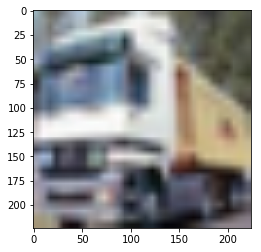

In [9]:
def imshow(img):
    img = np.transpose(img, (1, 2, 0))
    img = img.numpy()
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean
    plt.imshow(img)
    plt.show()
    
imshow(trainingDataset[1][0])

### Split Training Dataset

Training and testing datasets are ready, but there are no validation dataset. There are 50000 images in training dataset. I will split training dataset into validation and training with 1/5 ratio.

At the end these are the length of the datasets:

* `training`: 40000
* `validation`: 10000
* `testing`: 10000

**SubsetRandomSampler** method samples elements randomly from a given list of indices, without replacement.



In [10]:
validation_split = 0.2
dataset_size = len(trainingDataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

### Data Loaders

Data loaders are useful for memory efficiency. To avoid loading all the images into memory, we can use DataLoaders to load batch of images. DataLoaders apply transformations and prepare batch of the data. Shuffle parameter is to have the data reshuffled at every epoch [6].

In [11]:
trainLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=128, sampler=train_sampler)
validationLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=128, sampler=validation_sampler)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=32, shuffle=False, num_workers=0)

Creating **dataloaders** and **dataset_sizes** dictionary for clean code when training the model.

In [12]:
dataloaders = {
    "train": trainLoader,
    "val": validationLoader,
    "test": testLoader
}
dataset_sizes = {
    "train": len(train_indices),
    "val": len(val_indices),
    "test": len(testDataset)
}


Shape of a train dataloader images is (batch_size, channel_size, height, width)

In [13]:
trainiter = iter(dataloaders['train'])
images, labels = next(trainiter)

images.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

## 3- ResNet-50 CNN Architecture
I wrote my ResNet-50 architecture. This code is mostly adapted from [5]. 

Usage: `model = resnet50(pretrained=True)`

If *pretrained* parameter is True, it downloads the pretrained network weights. ResNet-50 network was pretrained on ImageNet. 

In [14]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth'))
    return model



## 4- Training Model

This is a general method for training a model [7]. Input parameters:

* `model`: Network model for training. In this example it is ResNet-50
* `criterion`: Loss function. For example nn.CrossEntropyLoss() - nn.HingeEmbeddingLoss
* `optimizer`: Optimizer for training. For example optim.Adam - optim.SGD
* `num_epochs`: Epoch size.

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history_loss = {
        "train": [],
        "val": []
    }
    history_accuracy = {
        "train": [],
        "val": []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.long()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            #History Statistics
            history_loss[phase].append(epoch_loss)
            history_accuracy[phase].append(epoch_acc.item())
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history_loss, history_accuracy

## Save Model

In [16]:
def saveModel(model, name):
    if not os.path.exists('MODEL'):
        os.makedirs('MODEL')
    torch.save({'state_dict': model.state_dict()}, 'MODEL/'+name)

Initialize model with pretrained = True. ResNet-50 model weights are downloaded and used as initial weights. ResNet-50 is pretrained with ImageNet dataset.

In [17]:
model = resnet50(pretrained=True)

ResNet-50 Model architecture is shown below:

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

If GPU is supported, train model parallel.

In [19]:
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

## 5 - Optimizing Only Last Layer

### Freezing Layers
Freeze all layers with *requires_grad* parameter so that the gradients are not computed in backward().

In [20]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

Resetting final fully connected layer. Only this layer's weights are updated, other layers weights are fixed.

In [21]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

Give model to device (GPU or CPU)

In [22]:
model = model.to(device)

Let's create a function for freezing all layers except last one. This function is useful for clean coding.

In [23]:
def freezeLayersExceptLast():
    model = resnet50(pretrained=True)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model = model.to(device)

### Optimization with CrossEntropyLoss and SGD

I used loss function as **CrossEntropyLoss**, optimizer as **Stochastic Gradient Descent (SGD)** with momentum. Every 7 epochs learning rate is decayed by a factor 0.1.

In [24]:
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.0001, momentum=0.9)
#optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.0001)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

We can see, how many parameters exist in the entire network. Also we can see total training parameters after layer freezing. In this example there are `23,528,522` total parameters and `20,490` training parameters.

In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,528,522 total parameters.
20,490 training parameters.


I trained model for 10 epochs.

In [26]:
model, history_loss, history_accuracy = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.0178 Acc: 0.4256
val Loss: 1.7755 Acc: 0.6164

Epoch 1/9
----------
train Loss: 1.6130 Acc: 0.6583
val Loss: 1.4645 Acc: 0.6954

Epoch 2/9
----------
train Loss: 1.3751 Acc: 0.7061
val Loss: 1.2804 Acc: 0.7192

Epoch 3/9
----------
train Loss: 1.2240 Acc: 0.7229
val Loss: 1.1593 Acc: 0.7287

Epoch 4/9
----------
train Loss: 1.1219 Acc: 0.7330
val Loss: 1.0704 Acc: 0.7395

Epoch 5/9
----------
train Loss: 1.0461 Acc: 0.7423
val Loss: 1.0062 Acc: 0.7461

Epoch 6/9
----------
train Loss: 0.9912 Acc: 0.7462
val Loss: 0.9571 Acc: 0.7486

Epoch 7/9
----------
train Loss: 0.9646 Acc: 0.7501
val Loss: 0.9502 Acc: 0.7508

Epoch 8/9
----------
train Loss: 0.9613 Acc: 0.7500
val Loss: 0.9444 Acc: 0.7498

Epoch 9/9
----------
train Loss: 0.9556 Acc: 0.7514
val Loss: 0.9469 Acc: 0.7497

Training complete in 20m 25s
Best val Acc: 0.750800


In [27]:
saveModel(model, name="model_crossEntropyLoss_SGD_resnet_last_layer.pth")

### Plotting

As we can see from loss and accuracy plot, training and validation curves are close to each other. This means no overfitting occured. 

Text(0.5,1,'Training and Validation Losses')

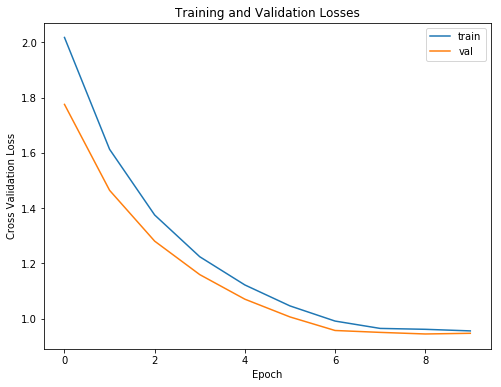

In [28]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_loss[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Validation Loss')
plt.title('Training and Validation Losses')

Text(0.5,1,'Training and Validation Accuracy')

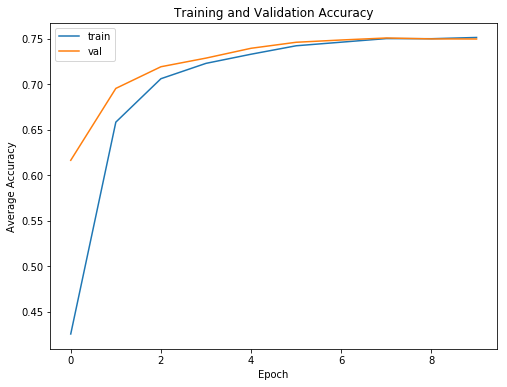

In [29]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_accuracy[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

### Accuracy on Test Dataset

Model is trained on training dataset with validation dataset. Now model is ready for test dataset. 

In [30]:
def accuracyOnTest():
    model.eval()
    running_corrects = 0
    
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.long()
        labels = labels.to(device)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        running_corrects += torch.sum(preds == labels.data)
    acc = running_corrects.double() / dataset_sizes['test']
        
    return acc

In [31]:
acc = accuracyOnTest()

In [32]:
acc.item()

0.7538

### Optimization with Hinge Loss and SGD

I used loss function as **MultiMarginLoss**, optimizer as **Stochastic Gradient Descent (SGD)** with momentum. Every 7 epochs learning rate is decayed by a factor 0.1.

MultiMarginLoss creates a criterion that optimizes a multi-class classification hinge loss (margin-based loss) between input x (a 2D mini-batch Tensor) and output y [8].

In [33]:
freezeLayersExceptLast()

In [34]:
criterion = nn.MultiMarginLoss()

optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [35]:
model, history_loss, history_accuracy = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1221 Acc: 0.7580
val Loss: 0.1124 Acc: 0.7730

Epoch 1/9
----------
train Loss: 0.1120 Acc: 0.7720
val Loss: 0.1068 Acc: 0.7804

Epoch 2/9
----------
train Loss: 0.1058 Acc: 0.7824
val Loss: 0.1025 Acc: 0.7878

Epoch 3/9
----------
train Loss: 0.1015 Acc: 0.7866
val Loss: 0.0989 Acc: 0.7891

Epoch 4/9
----------
train Loss: 0.0987 Acc: 0.7899
val Loss: 0.0966 Acc: 0.7964

Epoch 5/9
----------
train Loss: 0.0963 Acc: 0.7941
val Loss: 0.0958 Acc: 0.7968

Epoch 6/9
----------
train Loss: 0.0946 Acc: 0.7961
val Loss: 0.0930 Acc: 0.7995

Epoch 7/9
----------
train Loss: 0.0925 Acc: 0.7999
val Loss: 0.0924 Acc: 0.8010

Epoch 8/9
----------
train Loss: 0.0926 Acc: 0.7995
val Loss: 0.0929 Acc: 0.7994

Epoch 9/9
----------
train Loss: 0.0922 Acc: 0.7998
val Loss: 0.0922 Acc: 0.8001

Training complete in 20m 18s
Best val Acc: 0.801000


In [36]:
saveModel(model, name="model_HingeLoss_SGD_resnet_last_layer.pth")

### Plotting

Text(0.5,1,'Training and Validation Losses')

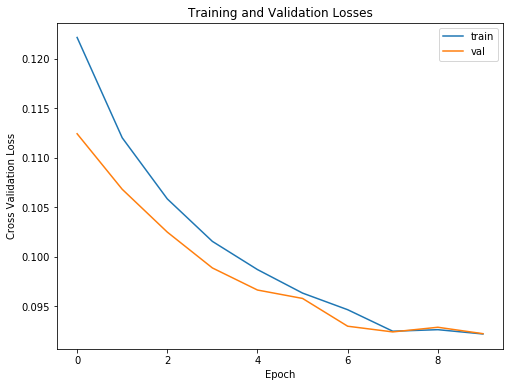

In [37]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_loss[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Validation Loss')
plt.title('Training and Validation Losses')

Text(0.5,1,'Training and Validation Accuracy')

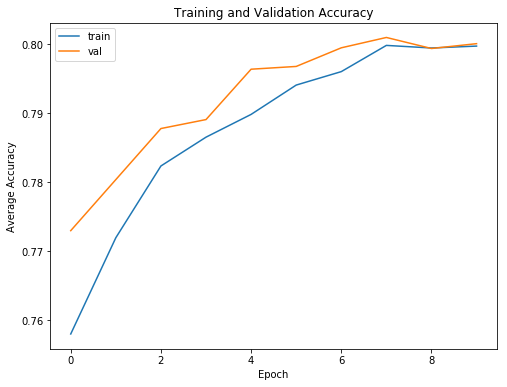

In [38]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_accuracy[c], label=c)
plt.legend()
#plt.ylim(1, 100)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

### Accuracy on Test Dataset

In [39]:
acc = accuracyOnTest()
acc.item()

0.7981

## 6 - Optimizing All of the Layers

In this part, I am using pretrained model's weights and optimize all of the layers of the model. This requires a lot of processing power and time compared to optimizing only last layer of the model. 

In [40]:
model = resnet50(pretrained=True)

In [41]:
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    
model = model.to(device)

We can see, how many parameters exist in the entire network. Also we can see total training parameters after layer freezing. In this example there are `25,557,032` total parameters and `25,557,032` training parameters. Because of there is no layer freezing, total parameters and training parameters are equal.

In [42]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

25,557,032 total parameters.
25,557,032 training parameters.


### Optimization with CrossEntropyLoss and SGD

In [43]:
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [44]:
model, history_loss, history_accuracy = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.0568 Acc: 0.4346
val Loss: 1.0512 Acc: 0.6396

Epoch 1/9
----------
train Loss: 0.9227 Acc: 0.6863
val Loss: 0.8190 Acc: 0.7180

Epoch 2/9
----------
train Loss: 0.7756 Acc: 0.7360
val Loss: 0.7216 Acc: 0.7526

Epoch 3/9
----------
train Loss: 0.7077 Acc: 0.7602
val Loss: 0.6717 Acc: 0.7710

Epoch 4/9
----------
train Loss: 0.6709 Acc: 0.7723
val Loss: 0.6448 Acc: 0.7809

Epoch 5/9
----------
train Loss: 0.6425 Acc: 0.7829
val Loss: 0.6281 Acc: 0.7844

Epoch 6/9
----------
train Loss: 0.6243 Acc: 0.7879
val Loss: 0.6121 Acc: 0.7918

Epoch 7/9
----------
train Loss: 0.6106 Acc: 0.7933
val Loss: 0.6040 Acc: 0.7942

Epoch 8/9
----------
train Loss: 0.6069 Acc: 0.7934
val Loss: 0.6044 Acc: 0.7936

Epoch 9/9
----------
train Loss: 0.6070 Acc: 0.7939
val Loss: 0.6028 Acc: 0.7943

Training complete in 34m 15s
Best val Acc: 0.794300


In [45]:
saveModel(model, name="model_crossEntropyLoss_SGD_resnet_all_layers.pth")

### Plotting

Text(0.5,1,'Training and Validation Losses')

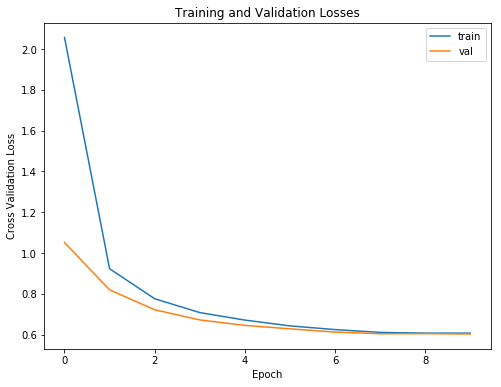

In [46]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_loss[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Validation Loss')
plt.title('Training and Validation Losses')

Text(0.5,1,'Training and Validation Accuracy')

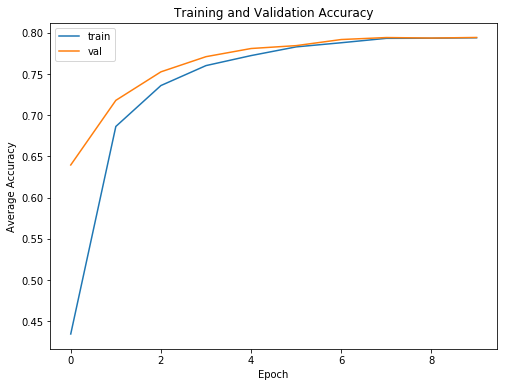

In [47]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_accuracy[c], label=c)
plt.legend()
#plt.ylim(1, 100)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

### Accuracy on Test Dataset

In [48]:
acc = accuracyOnTest()
acc.item()

0.791

### Optimization with Hinge Loss and SGD

In [56]:
model = resnet50(pretrained=True)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    
model = model.to(device)

In [57]:
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
#optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [58]:
model, history_loss, history_accuracy = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9575 Acc: 0.7049
val Loss: 0.6418 Acc: 0.7762

Epoch 1/9
----------
train Loss: 0.5974 Acc: 0.7933
val Loss: 0.5704 Acc: 0.8011

Epoch 2/9
----------
train Loss: 0.5634 Acc: 0.8030
val Loss: 0.5332 Acc: 0.8135

Epoch 3/9
----------
train Loss: 0.5456 Acc: 0.8080
val Loss: 0.5279 Acc: 0.8172

Epoch 4/9
----------
train Loss: 0.5270 Acc: 0.8175
val Loss: 0.5194 Acc: 0.8204

Epoch 5/9
----------
train Loss: 0.5068 Acc: 0.8235
val Loss: 0.5324 Acc: 0.8133

Epoch 6/9
----------
train Loss: 0.5065 Acc: 0.8252
val Loss: 0.4966 Acc: 0.8281

Epoch 7/9
----------
train Loss: 0.4617 Acc: 0.8391
val Loss: 0.4924 Acc: 0.8311

Epoch 8/9
----------
train Loss: 0.4618 Acc: 0.8400
val Loss: 0.4889 Acc: 0.8321

Epoch 9/9
----------
train Loss: 0.4597 Acc: 0.8413
val Loss: 0.4903 Acc: 0.8322

Training complete in 34m 17s
Best val Acc: 0.832200


In [59]:
saveModel(model, name="model_HingeLoss_SGD_resnet_all_layers.pth")

### Plotting

Text(0.5,1,'Training and Validation Losses')

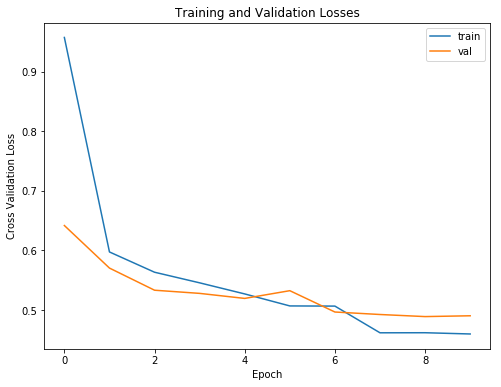

In [60]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_loss[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Validation Loss')
plt.title('Training and Validation Losses')

Text(0.5,1,'Training and Validation Accuracy')

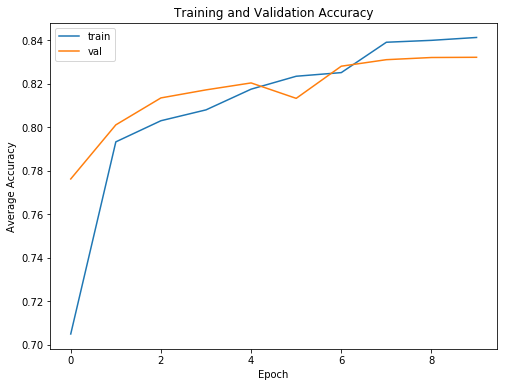

In [61]:
plt.figure(figsize=(8, 6))
for c in ['train', 'val']:
    plt.plot(
        history_accuracy[c], label=c)
plt.legend()
#plt.ylim(1, 100)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

### Accuracy on Test Dataset

In [62]:
acc = accuracyOnTest()
acc.item()

0.8267

## Test Accuracy For Different Methods

* Cross Entropy Loss - SGD - ResNet-50 - Fine Tune Only Last Layer = `0.7538`
* Hinge(Multi Margin) Loss - SGD - ResNet-50 - Fine Tune Only Last Layer = `0.7981`
* Cross Entropy Loss - SGD - ResNet-50 - Fine Tune All Layers = `0.791`
* Hinge(Multi Margin) Loss - SGD - ResNet-50 - Fine Tune All Layers = `0.8267`

## 7- Conclusion

I trained all the models on GPU. I used Google Cloud Compute Engine with Tesla V100 GPU. Training and validation dataset batch sizes are **128** and testing dataset batch size is **32**. I trained all the models for **10** epochs.

I used ResNet-50 model that is pretrained on ImageNet. First part of this notebook, I freezed all the layers except the last layer. I used Cross Validation loss and Hinge Loss with SGD (Stochastic Gradient Descent). I observed that, with equal learning rate for cross validation loss and hinge loss using SGD with momentum, hinge loss model converges very slowly. So I give a higher learning rate for hinge loss model training. First part model training took nearly 20 minutes.

Second part of the notebook, I did not freeze any layer, and all the weights are initialized with ResNet-50 pretrained model. I fine-tuned all the layers. Second part of the model training took nearly 34 minutes. This is expected because # of parameters are higher for the second part of the model and it requires more computational power.

As we can see from plots there is no overfitting issue for all the models, training and validation lines are close to each other during training.

Best test accuracy is `0.8267`. Because of the computational power and time, I determined epoch size as **10**. We can increase the accuracy by increasing epoch size. 

If you have any questions, please contact me on baltacifatih14@gmail.com

## References

[1] Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

[2] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770-778.

[3] https://luckydanny.blogspot.com/2016/07/load-cifar-10-dataset-in-python3.html

[4] https://pytorch.org/docs/stable/torchvision/transforms.html

[5] https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

[6] https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

[7] https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

[8] https://pytorch.org/docs/stable/nn.html#multimarginloss

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

https://www.aiworkbox.com/lessons/normalize-cifar10-dataset-tensor

https://discuss.pytorch.org/t/random-seed-initialization/7854/7

https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

https://pytorch.org/docs/stable/optim.html

https://stackoverflow.com/questions/50544730/split-dataset-train-and-test-in-pytorch-using-custom-dataset

https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb